# What you'll learn

After watching this video, you will be able to:
* Explain how to create your own tasks for quality checks and testing.
* Describe how to add environment properties to a task.
* Describe how to specify when tasks should run in parallel.

# Complete Pipeline

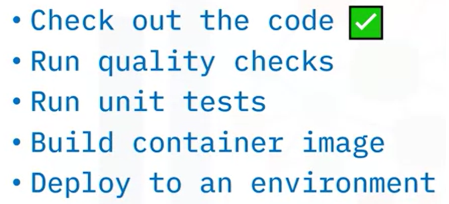

* Let's look at where you are in building a complete pipeline using Tekton.
* In previous videos, you’ve seen **two ways to create the checkout stage of a pipeline**, so you have that completed.
* Now it's time to build the other stages.

# CD pipeline

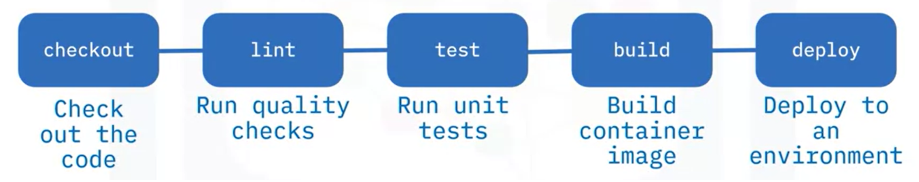

* To visualize this pipeline, you can think of it as a linear progression of **tasks**, to `check out`, `lint`, `test`, `build`, and `deploy` your application.
* But in reality, quality checks like running lint and unit testing are completely independent.

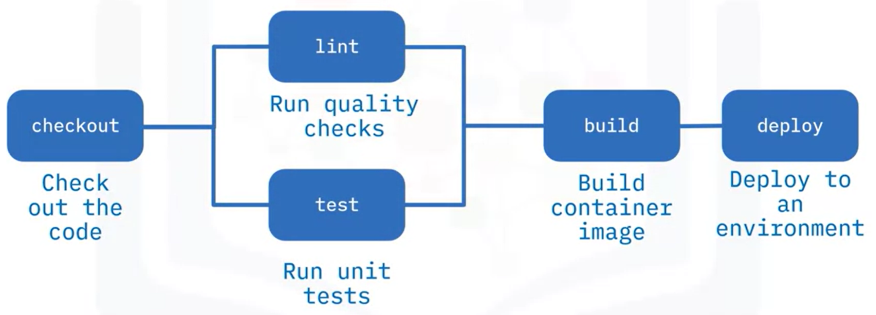

	• So, the pipeline can look like this with quality checks and unit tests running in parallel.
	• If either one of them fails, the pipeline will stop, but the run order really doesn't matter.
	• This allows you to take advantage of Tekton's parallel processing to speed up the pipeline run.

Let's look at testing first.

# Test case automation

**Testing is critically important for any CI/CD pipeline.**
* You perform unit testing in the CI pipeline.
* You perform integration testing in the CD pipeline.
* Whichever type of testing, test cases ensure that your code is behaving as intended.
* For a CD pipeline, this is the final opportunity to check for any problems before the code is deployed.
* The Tekton catalog has many testing tools to choose from, but **what if the tool that you use isn’t in the catalog?** 
* In this case, you can simply build your own tasks to run the tool you’re already using to automate your tests.

# Testing Scripts

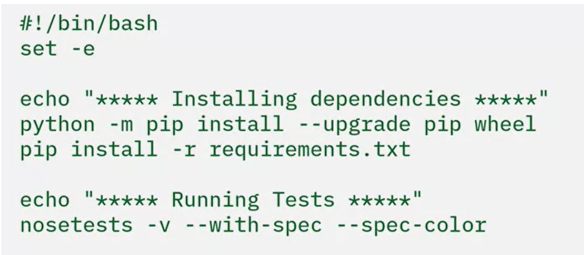

Creating your own task is quite simple.
* You start with a script that you probably already have.
* This script starts out by **upgrading `pip` and `wheel`** so that you’re using the latest versions.
* Then, it uses `pip`, the Python package manager, to **install the required Python package dependencies**.
* Finally, it runs the Python test runner called `nosetests` and passes in some parameters to make the output colorful.

You can use this exact script in your Tekton task, which means that the same commands your developers are using to test their code locally can be used in your pipeline as well.

# Define your own task

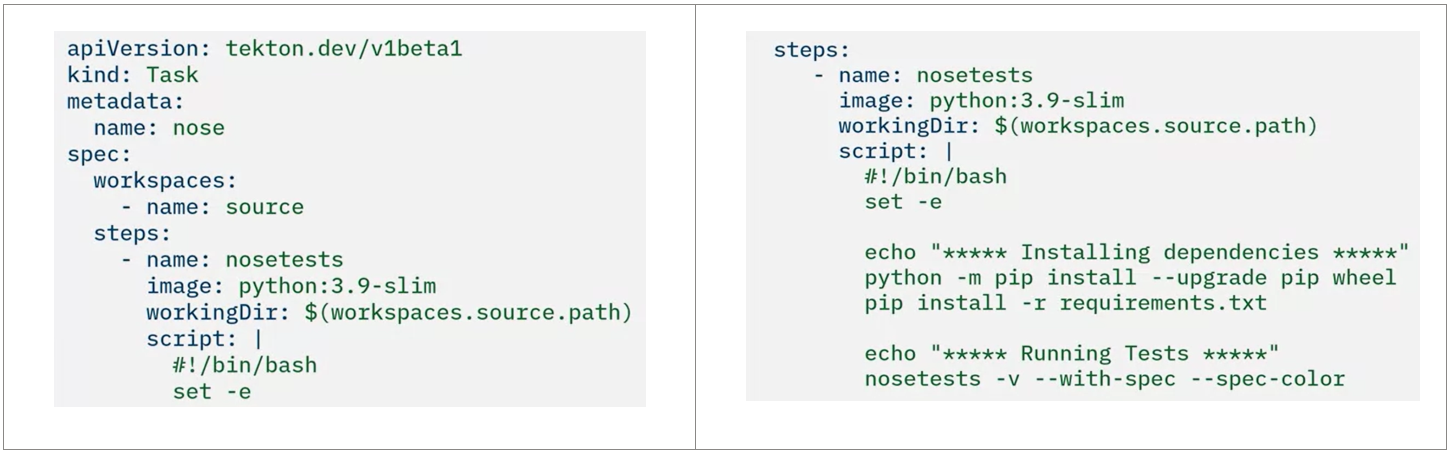

You can write your own **task** that uses this script.

You start by specifying the Tekton `apiVersion`, and tell Kubernetes that this resource `kind` is a `task`.

Next, you give it a `name`. You will be running a tool called **"nose"** so you call the task `nose` so that it will be easy to identify in the future.

Now you can start writing the specifications (`spec`).
* Since you want to run the test cases against your code, you need a `workspace` that a previous tasks in the pipeline can place the code into.
* A common workspace name that many tasks use for code is **"source"** so you `name` the `workspace` **"source"** for consistency.

Now, you are ready to write the `steps`.
* You create a step and call it **"nosetests"** since this is the actual name of the command that you will be using.
* This is also the name that the logs will show when this task runs.
* Since all the **steps run in a container**, you need to specify the **name of the image** that the container should be created from.
* You're testing Python code, so you specify the **"python:3.9-slim"** image, which also happens to be the same image that your developers use for their development. This should minimize any surprises when testing.

You want to be sure that when your test command runs, it's in the same directory as the code.
* You use the **"`workingDir`"** option to specify the path of the root of the workspace.
* To do this, you use the word **"`workspaces.`"** followed by the name of the workspace, which is **"`source`"**, followed by the word **"`.path`"**.
* That makes the reference **"`$(workspaces.source.path)`"**.

The only thing left to do is insert your script. You use the **"script"** parameter with a vertical bar to indicate that the script will be specified in-line on the lines that follow, and you paste your script below it.

> This is the full step implementation after adding your script. That's how easy it is to take existing scripts and incorporate them into your Tekton pipeline. **This works great until you realize your test cases require a database**. The database URI is normally specified as an environment variable.

Let's look at how to handle this.

# Using environment properties

**Cloud native applications** should follow the **12-factor guidelines**, which define how to deliver **software-as-a-service** applications.
* **Factor number `#3`** is all about configuration.
* In particular, **it states that configuration should be specified in the environment**.
* As a result, it has been widely adopted by the microservice architecture.
* Every cloud provider has a way of injecting environment properties into the runtime for things like database URIs so that your application knows how to connect to the database.

Let's take a look at **how you can use environment variables in Tekton to provide a database URI for your tests**.

# Secret Credentials

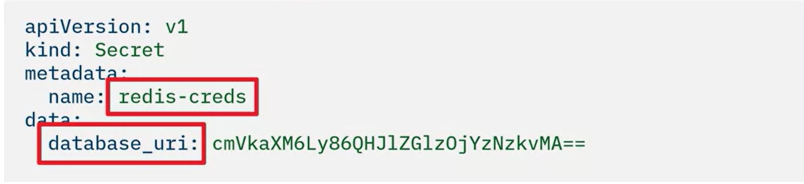

Let's say you have a secret named **"`redis-creds`"** defined in your Kubernetes cluster.
* It has a data value called **"`database_uri`"** that contains the **base64-encoded credentials and URL** to make the database connection.
* Your test cases are expecting this to be available as an environment variable called all uppercase `DATABASE_URI` so that they can connect to the test database.

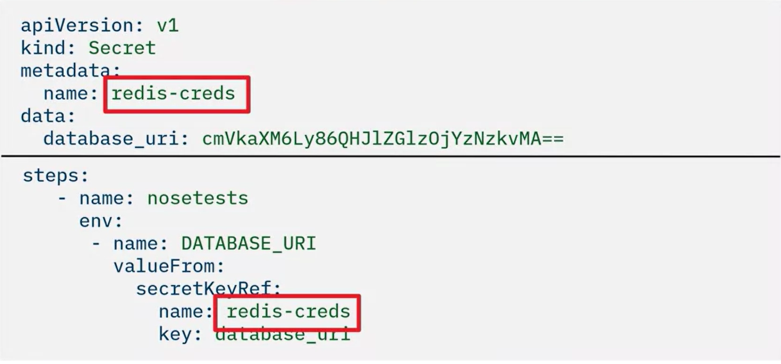

Let's look at how to define this.

In the `nosetests` task in your **Tekton steps**, you can **create an environment definition** to make this variable available to your task. 
* The `name` should be the **name of the environment variable** that your test cases are expecting.
* In this example, that’s `DATABASE_URI`, all uppercase.
* You define that the value is coming from a secret.
* The `name` of that secret is **"`redis-creds`"**, and the data key is called **"`database_uri`"**.
* This is what maps the value of the key in the secret to the value of the environment variable that your tests see.

# Update the task

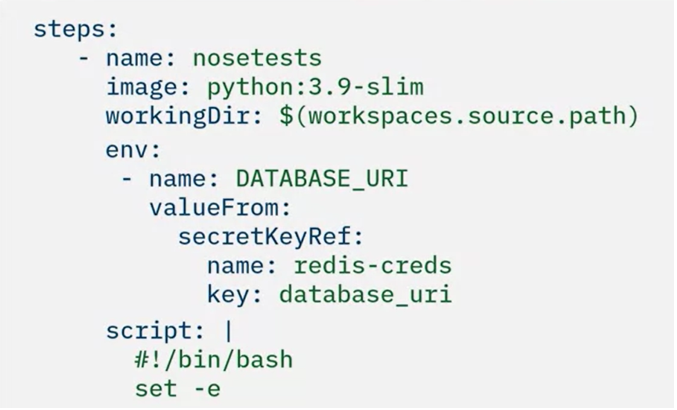

Let's see how you can add this to your Tekton task.
* This is your current task.
* You can insert the environment definition anywhere in the step, so you add it right above the script.
* You move the script down to make some room, and paste the code from the previous example.
* And you're done! It's that simple.

Now when these test cases run, the environment variable called `DATABASE_URI` will be available for the tests to use to connect to the database.
* As mentioned earlier, all cloud providers have a way of injecting environment properties into their runtimes.
* So, this technique can also be used when running Tekton pipelines in a cloud environment.

# Linting Script

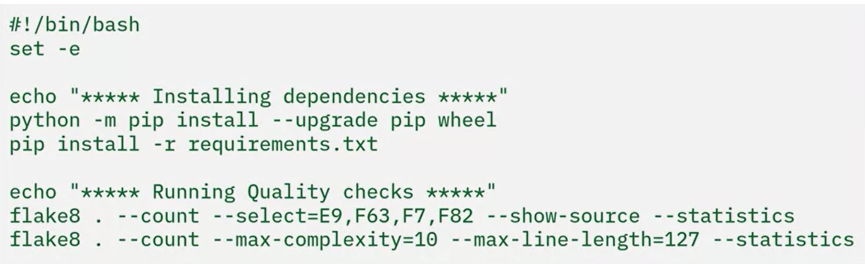

You use the same method for **creating your own task for quality checks like linting**.
* You start with a script that you already have.
* Just like the test script, this script starts out by **upgrading `pip` and `wheel`** so that you’re using the latest version.
* Then, it uses `pip` **to install the required Python package dependencies**.
* Finally, it runs the `flake8` command to check for any quality issues.

Once again, you can use this exact script in your **Tekton task**, which means that the same commands developers are using to `lint` their code locally can be used in your Tekton pipeline as well.
* You could also make it more generic and pass in the arguments as parameters.
* You can decide how flexible you want to make it.

# Add tests and lint to the pipeline

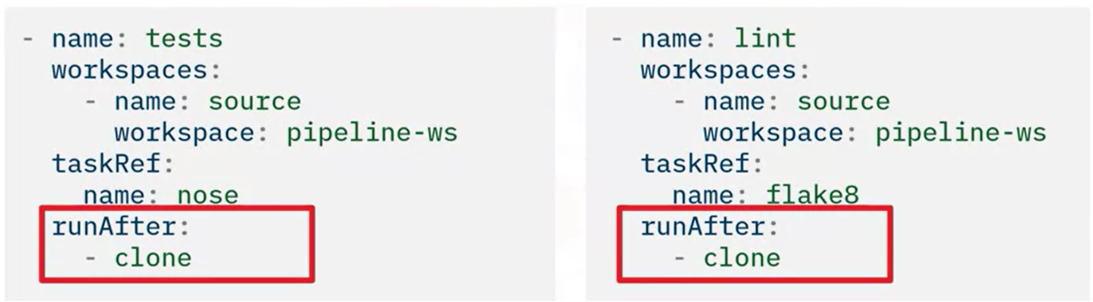

Now, let's look at how you can add these two new steps to the pipeline.
* You define a new pipeline task and give it a name.
* In this example, you name it **`tests`**.
* You specify any **`workspaces`** needed to share the code from previous tasks.
* Then, you refer to the task you just wrote, called **`nose`**.
* This tells Tekton to run the **`nose`** task.
* Finally, you tell Tekton when to run this pipeline task and specify to run it after the `clone` task because you must clone the code from GitHub before you can run tests on it.
* The lint task is much the same except that it uses the name `lint` and references the `flake8` task you created.
* These two tasks run in parallel because they both specified to run after the clone task.
* So, both tasks will run after the clone task completes.

# Summary

You learned that:
* You can write your own task if one doesn't exist in the **Tekton catalog**.
* These tasks can use existing shell scripts that you already have.
* You can define environment variables to pass configuration information into a task.
* Tasks like tests and quality checks, can be run serially or in parallel, depending on your needs.